# Dependencies and prerequisites

In [ ]:
# Plots
import matplotlib.pyplot as plt
# Math
import numpy as np
# Keystone of whole processing - NLTK
from nltk import tokenize
import nltk
nltk.download('punkt')
# DataFrames
import pandas as pd
# File operations
from pathlib import Path
# Regular expression for optimal string processing.
import re
# Pretty print. Not nessesary but I quite like it.
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Consistent seed will keep you sane - Andrej Karpathy
import random
random.seed(42)
from random import shuffle

# Language detection by Nakatani Shuyo
from langdetect import detect, DetectorFactory
# NOTE
# Language detection algorithm is non-deterministic, 
# which means that if you try to run it on a text which is either too short 
# or too ambiguous, you might get different results everytime you run it.
# To enforce consistent results, 
# call following code before the first language detection:
DetectorFactory.seed = 0

# JSON - not that required, if you dont like it, use other tool to save 
# sentences in different languages separately.
import json

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Garnik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Input data
Load the files.
Feel free to change the variable data_file to be your txt file.

In [ ]:
lines = []
data_file = Path('data/tiny_s/tiny_shakespeare.txt')
with data_file.open() as fd:
    original_lines = fd.readlines()
N = len(lines)
print(f'Dataset contains {N} lines.')
print('First 30 lines')
pp.pprint(original_lines[:30])

Dataset contains 0 lines.
First 30 lines
[   'First Citizen:\n',
    'Before we proceed any further, hear me speak.\n',
    '\n',
    'All:\n',
    'Speak, speak.\n',
    'Test.\n',
    'Best.\n',
    '\n',
    'First Citizen:\n',
    'You are all resolved rather to die than to famish?\n',
    '\n',
    'All:\n',
    'Resolved. resolved.\n',
    '\n',
    'First Citizen:\n',
    'First, you know Caius Marcius is chief enemy to the people.\n',
    '\n',
    'All:\n',
    "We know't, we know't.\n",
    '\n',
    'First Citizen:\n',
    "Let us kill him, and we'll have corn at our own price.\n",
    "Is't a verdict?\n",
    '\n',
    'All:\n',
    "No more talking on't; let it be done: away, away!\n",
    '\n',
    'Second Citizen:\n',
    'One word, good citizens.\n',
    '\n']


# Preprocessing
In case of Shakespeare dataset we delete empty lines and speaking person notation.

In [ ]:
lines = []
flag = False
re_speaker = re.compile('^\n.*:\n$') # Since speaker always precedes with \n and ends with :\n double line approach is useful
for line1, line2 in zip(original_lines[1:], original_lines[2:]):
    if flag:
        flag = False
        continue
    line = line1 + line2
    if re_speaker.fullmatch(line):
        flag = True
    else:
        lines.append(line1)

# pp.pprint(lines[:30])
print(f'Filtered dataset has {len(lines)} lines.')

Filtered dataset has 25558 lines.


If you are using other languages I recommend filtering out unbreakable spaces `\xa0` for French language and generally repeated whitespace characters overall.

In [ ]:
for line in lines:
  line = re.sub(r'(\s|\xa0)+', ' ', line)

# Statistics
Save the dataset and use nltk to get some insights. We will actually use HuggingFace tokenizers later, but for now nltk is useful.

In [ ]:
#Save
output_file = Path('data/tiny_s/tiny_shakespeare_01_simple_filtered.txt')
with output_file.open(mode='w', encoding='utf-8') as fd:
    fd.writelines(lines)

Get sentences.

In [ ]:
sentences = tokenize.sent_tokenize(' '.join(lines).replace('\n',''), language='english')
len(sentences)

12460

If you have multiple languages in your text, it is a good idea to run following block to sort them to languge bins. Look through the sentences that didn't get recognized or were recongized unexpectedly. Usually it useful to just throw them out since they have a lot of typos or tokenizer had problems with them (yes, german tokenizer, I'm looking at you).

In [ ]:
# split text into sentences
sentence_lang = {}

for sentence in sentences:
    try:
        lang = detect(sentence)
        if lang not in sentence_lang.keys():
            sentence_lang[lang] = []
        sentence_lang[lang].append(sentence)
#         print(f"'{sentence}' is in {lang}")
    except:
        print(f"Could not detect language of '{sentence}'")

for key in sentence_lang.keys():
    print("language ", key, " , len =",len(sentence_lang[key]))
# Dump into JSON if you wish to do so
json_file = Path('data/tiny_s/tiny_shakespeare.json').touch(exist_ok=True)
with json_file.open("w", encoding="UTF-8") as fd:
  json.dump(sentence_lang, fd)

Check how many words are in sentences. If you have 200 words in a sentence, better check it.

211


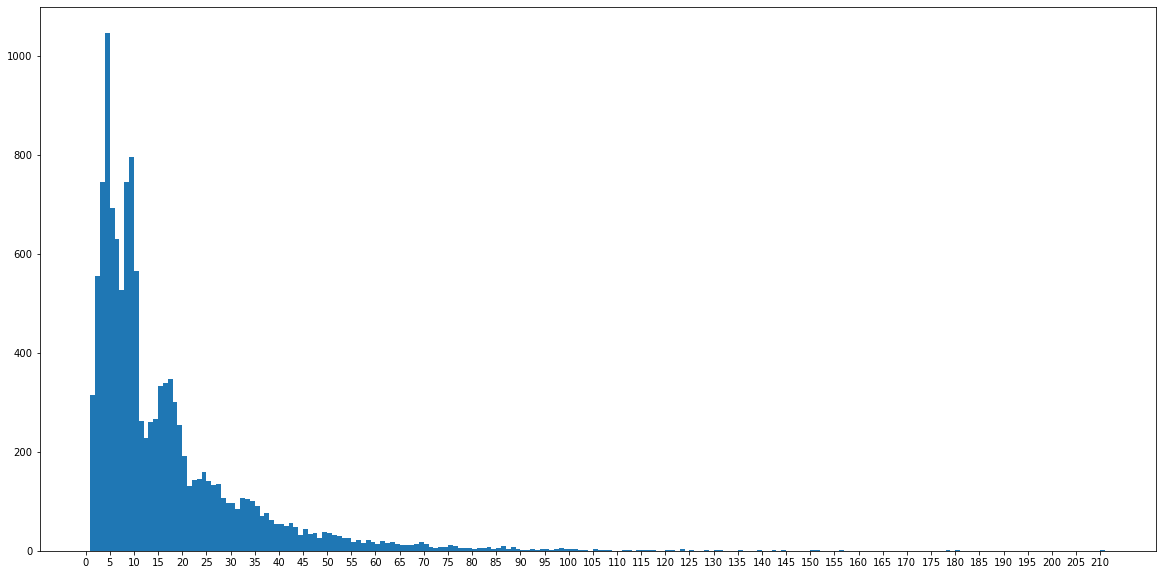

In [ ]:
def count_words(s):
    return len(tokenize.regexp_tokenize(s, r'\w+'))

m = max(list(map(count_words, sentences)))
print(m)
fig, ax = plt.subplots(figsize=(20, 10))
n, b, _ = ax.hist(list(map(count_words, sentences)), bins=m-1)
plt.xticks(np.arange(0, m+1, 5))
plt.show()

In [ ]:
# Let's see the max length sentence. Yes, Sir William Shakespeare managed 200+ word sentence.
index_max = np.argmax(list(map(count_words, sentences)))
sentences[index_max]

"This royal throne of kings, this scepter'd isle, This earth of majesty, this seat of Mars, This other Eden, demi-paradise, This fortress built by Nature for herself Against infection and the hand of war, This happy breed of men, this little world, This precious stone set in the silver sea, Which serves it in the office of a wall, Or as a moat defensive to a house, Against the envy of less happier lands, This blessed plot, this earth, this realm, this England, This nurse, this teeming womb of royal kings, Fear'd by their breed and famous by their birth, Renowned for their deeds as far from home, For Christian service and true chivalry, As is the sepulchre in stubborn Jewry, Of the world's ransom, blessed Mary's Son, This land of such dear souls, this dear dear land, Dear for her reputation through the world, Is now leased out, I die pronouncing it, Like to a tenement or pelting farm: England, bound in with the triumphant sea Whose rocky shore beats back the envious siege Of watery Nept

In [ ]:
# check for single word sentences. Sometimes you want to delete them or leave only unique.
unique = {}
for sentence in sentences:
    sentence = sentence.lower()
    if count_words(sentence) == 1:
        if sentence not in unique.keys():
            unique[sentence] = 1
        else:
            unique[sentence] +=1
single_sent_counts = pd.DataFrame(unique, index=['occurences']).T.sort_values('occurences', ascending=False)
single_sent_counts

,occurences
what!,17
how!,16
ha!,14
no.,9
away!,8
...,...
marry.,1
royally!,1
'zounds!,1
guilty!,1


We can preserve some of more often used ones and remove other ones with occurences > 2 but there is no need for that.

In [ ]:
# Uncomment if you want to
# Preserve
# single_sent_counts.drop(index='what!', inplace=True)
# single_sent_counts.drop(index='what?', inplace=True)
# Remove
# sentences = list(filter(lambda s: s not in single_sent_counts.index[single_sent_counts['occurences'] > 2].tolist(), sentences))

Save

In [ ]:
# Save
output_file = Path('data/tiny_s/tiny_shakespeare_02_fine_filtered.txt')
with output_file.open(mode='w', encoding='utf-8') as fd:
    fd.writelines(sentences)

Shuffle and create splits.

In [ ]:
shuffle(sentences)
output_file = Path('data/tiny_s/tiny_shakespeare_03_shuffled.txt')
with output_file.open(mode='w', encoding='utf-8') as fd:
    fd.writelines(sentences)

In [ ]:
# Not exactly 80% since sentences are different, but we can check the actual token count later.
# If it is close enough to 80% it's fine
# You can actually use scikit train_test_split, but since we manually shuffled, we can keep it simple.
train_index = int(0.8 * len(sentences))
test_index = int(0.9 * len(sentences))


train_set = sentences[:train_index]
test_set = sentences[train_index:test_index]
val_set = sentences[test_index:]

full_token_count = np.sum(list(map(count_words, sentences)))
train_token_count = np.sum(list(map(count_words, train_set)))
test_token_count = np.sum(list(map(count_words, test_set)))
val_token_count = np.sum(list(map(count_words, val_set)))


print(f'Full set has {full_token_count} tokens.')
print(f'Training set has {train_token_count} tokens, which is {train_token_count/full_token_count*100:.1f}% of dataset.')
print(f'Test set has {test_token_count} tokens, which is {test_token_count/full_token_count*100:.1f}% of dataset.')
print(f'Validation set has {val_token_count} tokens, which is {val_token_count/full_token_count*100:.1f}% of dataset.')

train_file = Path('data/tiny_s/tiny_shakespeare_04_train.txt')
with train_file.open(mode='w', encoding='utf-8') as fd:
    fd.writelines(train_set)

test_file = Path('data/tiny_s/tiny_shakespeare_04_test.txt')
with test_file.open(mode='w', encoding='utf-8') as fd:
    fd.writelines(test_set)

val_file = Path('data/tiny_s/tiny_shakespeare_04_val.txt')
with val_file.open(mode='w', encoding='utf-8') as fd:
    fd.writelines(val_set)

Full set has 198704 tokens.
Training set has 158158 tokens, which is 79.6% of dataset.
Test set has 19766 tokens, which is 9.9% of dataset.
Validation set has 20780 tokens, which is 10.5% of dataset.
